In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0501test_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.4
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 9s 824ms/step - loss: 0.3412
Average validation loss: 0.6384076476097107
4/4 [==============================] - 9s 839ms/step - loss: 0.3412 - val_loss: 0.6384
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 12s 766ms/step - loss: 0.2630 - val_loss: 0.6384
Average validation loss: 0.5001047253608704
4/4 [==============================] - 12s 790ms/step - loss: 0.2630 - val_loss: 0.5693
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 15s 771ms/step - loss: 0.2088 - val_loss: 0.5693
Average validation loss: 0.40545588731765747
4/4 [==============================] - 15s 788ms/step - loss: 0.2088 - val_loss: 0.5147
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 819ms/step - loss: 0.0203
Average validation loss: 8.878940985224126e-11
8/8 [==============================] - 7s 831ms/step - loss: 0.0203 - val_loss: 8.8789e-11
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 772ms/step - loss: 0.0189 - val_loss: 8.8789e-11
Average validation loss: 0.0
8/8 [==============================] - 13s 785ms/step - loss: 0.0189 - val_loss: 4.4395e-11
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 19s 764ms/step - loss: 0.0183 - val_loss: 4.4395e-11
Average validation loss: 0.0
8/8 [==============================] - 19s 778ms/step - loss: 0.0183 - val_loss: 2.9596e-11
Epoch 4/10
8/8 [==============================] - 26s 783ms/step -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 719ms/step - loss: 0.0234
Average validation loss: 0.12351207776430329
12/12 [==============================] - 9s 734ms/step - loss: 0.0234 - val_loss: 0.1235
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 702ms/step - loss: 0.0238 - val_loss: 0.1235
Average validation loss: 0.044061636672798464
12/12 [==============================] - 17s 718ms/step - loss: 0.0238 - val_loss: 0.0838
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 720ms/step - loss: 0.0234 - val_loss: 0.0838
Average validation loss: 0.0847758401722795
12/12 [==============================] - 26s 735ms/step - loss: 0.0234 - val_loss: 0.0841
Epoch 4/10
12/12 [==========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 724ms/step - loss: 0.0220
Average validation loss: 0.4189804494380951
16/16 [==============================] - 12s 737ms/step - loss: 0.0220 - val_loss: 0.4190
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 735ms/step - loss: 0.0204 - val_loss: 0.4190
Average validation loss: 0.06618530501646092
16/16 [==============================] - 24s 747ms/step - loss: 0.0204 - val_loss: 0.2426
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 723ms/step - loss: 0.0190 - val_loss: 0.2426
Average validation loss: 0.06003808368666341
16/16 [==============================] - 36s 734ms/step - loss: 0.0190 - val_loss: 0.1817
Saved model weights to 'c:\Users\user\Deskt

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 719ms/step - loss: 0.0108
Average validation loss: 0.03928731282358058
20/20 [==============================] - 15s 732ms/step - loss: 0.0108 - val_loss: 0.0393
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 713ms/step - loss: 0.0097 - val_loss: 0.0393
Average validation loss: 0.04489268997822364
20/20 [==============================] - 29s 725ms/step - loss: 0.0097 - val_loss: 0.0421
Epoch 3/10
20/20 [==============================] - 43s 709ms/step - loss: 0.0093 - val_loss: 0.0421
Average validation loss: 0.045818567052083384
20/20 [==============================] - 44s 723ms/step - loss: 0.0093 - val_loss: 0.0433
Epoch 4/10
20/20 [==============================] - 58s 724ms/step - loss: 0.0090 - val_loss: 0.0433
Average validation loss: 0.03147727817490065
20/20 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 735ms/step - loss: 0.0119
Average validation loss: 0.06493839745720227
24/24 [==============================] - 18s 746ms/step - loss: 0.0119 - val_loss: 0.0649
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 718ms/step - loss: 0.0109 - val_loss: 0.0649
Average validation loss: 0.07962564503153165
24/24 [==============================] - 35s 729ms/step - loss: 0.0109 - val_loss: 0.0723
Epoch 3/10
24/24 [==============================] - 53s 720ms/step - loss: 0.0101 - val_loss: 0.0723
Average validation loss: 0.07807642842332523
24/24 [==============================] - 53s 731ms/step - loss: 0.0101 - val_loss: 0.0742
Epoch 4/10
24/24 [==============================] - 70s 718ms/step - loss: 0.0097 - val_loss: 0.0742
Average validation loss: 0.02501105486104886
24/24 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 719ms/step - loss: 0.0156
Average validation loss: 0.027710860408842564
40/40 [==============================] - 29s 730ms/step - loss: 0.0156 - val_loss: 0.0277
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 716ms/step - loss: 0.0143 - val_loss: 0.0277
Average validation loss: 0.02637755135074258
40/40 [==============================] - 58s 728ms/step - loss: 0.0143 - val_loss: 0.0270
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 87s 719ms/step - loss: 0.0136 - val_loss: 0.0270
Average validation loss: 0.024773201160132884
40/40 [==============================] - 88s 730ms/step - loss: 0.0136 - val_loss: 0.0263
Saved model weights to 'c:\Users\user\De

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 719ms/step - loss: 0.0113
Average validation loss: 0.016262226815645892
48/48 [==============================] - 35s 731ms/step - loss: 0.0113 - val_loss: 0.0163
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 718ms/step - loss: 0.0101 - val_loss: 0.0163
Average validation loss: 0.01693787080391
48/48 [==============================] - 70s 731ms/step - loss: 0.0101 - val_loss: 0.0166
Epoch 3/10
48/48 [==============================] - 106s 732ms/step - loss: 0.0095 - val_loss: 0.0166
Average validation loss: 0.06991149826596181
48/48 [==============================] - 106s 743ms/step - loss: 0.0095 - val_loss: 0.0344
Epoch 4/10
48/48 [==============================] - 141s 722ms/step - loss: 0.0087 - val_loss: 0.0344
Average validation loss: 0.047069588055213295
48/48 [===========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 727ms/step - loss: 0.0118
Average validation loss: 0.016816545710233704
56/56 [==============================] - 41s 739ms/step - loss: 0.0118 - val_loss: 0.0168
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 729ms/step - loss: 0.0094 - val_loss: 0.0168
Average validation loss: 0.2688076049089432
56/56 [==============================] - 83s 741ms/step - loss: 0.0094 - val_loss: 0.1428
Epoch 3/10
56/56 [==============================] - 123s 718ms/step - loss: 0.0081 - val_loss: 0.1428
Average validation loss: 0.015600347093173436
56/56 [==============================] - 124s 729ms/step - loss: 0.0081 - val_loss: 0.1004
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_70.pth'.
Epoch 4/10
56/56 [=====================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 722ms/step - loss: 0.0083
Average validation loss: 0.020572864799760282
64/64 [==============================] - 47s 733ms/step - loss: 0.0083 - val_loss: 0.0206
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 717ms/step - loss: 0.0068 - val_loss: 0.0206
Average validation loss: 0.016866925987415016
64/64 [==============================] - 94s 728ms/step - loss: 0.0068 - val_loss: 0.0187
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 139s 716ms/step - loss: 0.0061 - val_loss: 0.0187
Average validation loss: 0.010587268669041805
64/64 [==============================] - 140s 727ms/step - loss: 0.0061 - val_loss: 0.0160
Saved model weights to 'c:\Users\user

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 53s 738ms/step - loss: 0.0073
Average validation loss: 0.008380041483582722
72/72 [==============================] - 54s 749ms/step - loss: 0.0073 - val_loss: 0.0084
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 106s 725ms/step - loss: 0.0059 - val_loss: 0.0084
Average validation loss: 0.008328343896816174
72/72 [==============================] - 107s 736ms/step - loss: 0.0059 - val_loss: 0.0084
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 160s 733ms/step - loss: 0.0052 - val_loss: 0.0084
Average validation loss: 0.010600206907838583
72/72 [==============================] - 161s 745ms/step - loss: 0.0052 - val_loss: 0.0091
Epoch 4/10
72/72 [=================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 63s 787ms/step - loss: 0.0079
Average validation loss: 0.008086280548013747
80/80 [==============================] - 64s 799ms/step - loss: 0.0079 - val_loss: 0.0081
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 128s 797ms/step - loss: 0.0064 - val_loss: 0.0081
Average validation loss: 0.008870179043151438
80/80 [==============================] - 129s 809ms/step - loss: 0.0064 - val_loss: 0.0085
Epoch 3/10
80/80 [==============================] - 192s 791ms/step - loss: 0.0057 - val_loss: 0.0085
Average validation loss: 0.007191278180107475
80/80 [==============================] - 193s 803ms/step - loss: 0.0057 - val_loss: 0.0080
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_100.pth'.
Epoch 4/10
80/80 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 70s 728ms/step - loss: 0.0102
Average validation loss: 0.04404753391532751
96/96 [==============================] - 71s 738ms/step - loss: 0.0102 - val_loss: 0.0440
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 140s 717ms/step - loss: 0.0083 - val_loss: 0.0440
Average validation loss: 0.025062714043248075
96/96 [==============================] - 141s 729ms/step - loss: 0.0083 - val_loss: 0.0346
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 210s 714ms/step - loss: 0.0072 - val_loss: 0.0346
Average validation loss: 0.021104235997232657
96/96 [==============================] - 211s 726ms/step - loss: 0.0072 - val_loss: 0.0301
Saved model weights to 'c:\Users\u

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 94s 787ms/step - loss: 0.0078
Average validation loss: 0.06204641143513593
120/120 [==============================] - 96s 800ms/step - loss: 0.0078 - val_loss: 0.0620
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 191s 794ms/step - loss: 0.0065 - val_loss: 0.0620
Average validation loss: 0.31022768053868505
120/120 [==============================] - 193s 806ms/step - loss: 0.0065 - val_loss: 0.1861
Epoch 3/10
120/120 [==============================] - 287s 787ms/step - loss: 0.0058 - val_loss: 0.1861
Average validation loss: 0.031136846221261293
120/120 [==============================] - 289s 799ms/step - loss: 0.0058 - val_loss: 0.1345
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_150.pth'.
Epoch 4/10
120/120 [===

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 113s 787ms/step - loss: 0.0068
Average validation loss: 0.007053976453284526
144/144 [==============================] - 115s 800ms/step - loss: 0.0068 - val_loss: 0.0071
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 228s 782ms/step - loss: 0.0050 - val_loss: 0.0071
Average validation loss: 0.013279274767135184
144/144 [==============================] - 230s 794ms/step - loss: 0.0050 - val_loss: 0.0102
Epoch 3/10
144/144 [==============================] - 342s 780ms/step - loss: 0.0044 - val_loss: 0.0102
Average validation loss: 0.026368112175365215
144/144 [==============================] - 344s 792ms/step - loss: 0.0044 - val_loss: 0.0156
Epoch 4/10
144/144 [==============================] - 456s 781ms/step - loss: 0.0042 - val_loss: 0.0156
Average validation loss: 0.017705719333763328
144/144 [=

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 114s 713ms/step - loss: 0.0048
Average validation loss: 0.0054694183568926745
160/160 [==============================] - 116s 724ms/step - loss: 0.0048 - val_loss: 0.0055
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 720ms/step - loss: 0.0041 - val_loss: 0.0055
Average validation loss: 0.004472274429792833
160/160 [==============================] - 233s 731ms/step - loss: 0.0041 - val_loss: 0.0050
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 347s 716ms/step - loss: 0.0036 - val_loss: 0.0050
Average validation loss: 0.0173400914811765
160/160 [==============================] - 349s 727ms/step - loss: 0.0036 - val_loss: 0.0091
Epoch 4/10
160/160 [

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 717ms/step - loss: 0.0078
Average validation loss: 0.010022232374504654
200/200 [==============================] - 146s 728ms/step - loss: 0.0078 - val_loss: 0.0100
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 288s 714ms/step - loss: 0.0066 - val_loss: 0.0100
Average validation loss: 0.007186030878943086
200/200 [==============================] - 291s 725ms/step - loss: 0.0066 - val_loss: 0.0086
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 434s 717ms/step - loss: 0.0056 - val_loss: 0.0086
Average validation loss: 0.00622079240617154
200/200 [==============================] - 436s 728ms/step - loss: 0.0056 - val_loss: 0.0078
Saved model weights 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:52 - loss: 0.0020

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 719ms/step - loss: 0.0058
Average validation loss: 0.009103915586456424
240/240 [==============================] - 175s 730ms/step - loss: 0.0058 - val_loss: 0.0091
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 347s 716ms/step - loss: 0.0046 - val_loss: 0.0091
Average validation loss: 0.0082153390563235
240/240 [==============================] - 350s 727ms/step - loss: 0.0046 - val_loss: 0.0087
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_40\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 522s 717ms/step - loss: 0.0040 - val_loss: 0.0087
Average validation loss: 0.013269581592327028
240/240 [==============================] - 525s 728ms/step - loss: 0.0040 - val_loss: 0.0102
Epoch 4/10
240/240 [=

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.08970596833764084, 0.09099105926351397, 0.15049053594238423, 0.0698513322581597, 0.05264217738829774, 0.05269394868208419, 0.08644914963850692, 0.09218247137163425, 0.056197506676951677, 0.04210248156254428, 0.033847407273787364, 0.019314555751660162, 0.024412044676649213, 0.03133248139186762, 0.019652688469866546, 0.015379054246099658, 0.010339279315275644, 0.00685727302349037]
std_val_losses =  [0.15190683100329982, 0.09333329758352689, 0.19848940472770965, 0.06783227436317751, 0.048430498551293374, 0.05919646426724143, 0.09998575845832422, 0.1169594510256188, 0.08282003031840436, 0.06627390172162925, 0.07460940976226164, 0.029973601989710476, 0.027225434841162705, 0.05286031464397837, 0.028315458676461264, 0.025122143848343773, 0.018550052039653504, 0.007636325941578687]


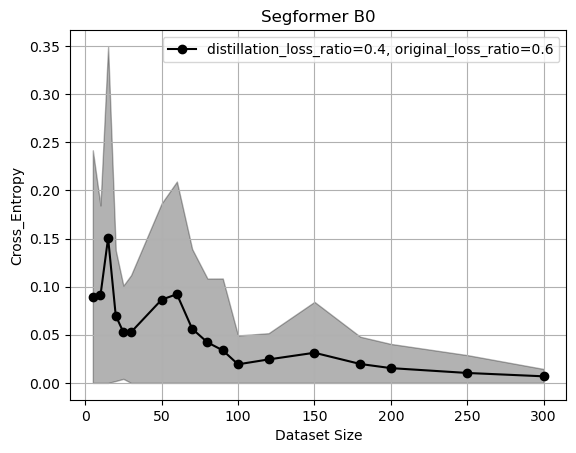

In [3]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()